In [8]:
import numpy as np
import _pickle as cPickle
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import warnings
import os, random
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from models import CNN
from models import RNN
from attacks import gradient_wrt_data

from utilities import process_data
from utilities import train_test_split
from utilities import evaluate_model
from utilities import evaluate_accuracy
from utilities import *

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset

In [12]:
seed = 5
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Device: ", device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Current Device:  cuda
Quadro RTX 6000


In [35]:
filename = "RML2016.10b.dat"
snrs, mods, X, labels = process_data(filename)

In [4]:
print(type(snrs))
print(type(mods))
print(type(X))
print(type(labels))
print(snrs.shape)
print(len(mods))
print(X.shape)
print(len(labels))

<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
(10,)
10
(600000, 2, 128)
600000


In [25]:
curr_model = "RNN"

#subsample = 1
#subsample = 2
#subsample = 4
subsample = 8

In [36]:
x_train0, x_test0, y_train, y_test, test_labels, test_idx = train_test_split(X, labels, mods, 
                                                    NN = curr_model)

#####################################################################
x_train = x_train0[:,:,::subsample]
x_test = x_test0[:,:,::subsample]

#####################################################################

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([480000, 2, 16])
torch.Size([120000, 2, 16])
torch.Size([480000])
torch.Size([120000])


In [27]:
if curr_model == "RNN" :
    batch_size = 64
    if subsample == 1 : 
        model = RNN(input_size = 128).to(device = device)
        model_checkpoint = "RNN_base.pt"
    if subsample == 2 :
        model = RNN(input_size = 64).to(device = device)
        model_checkpoint = "RNN_base_sub12.pt"
    if subsample == 4 :
        model = RNN(input_size = 32).to(device = device)
        model_checkpoint = "RNN_base_sub14.pt"
    if subsample == 8 :
        model = RNN(input_size = 16).to(device = device)
        model_checkpoint = "RNN_base_sub18.pt"

num_epochs = 100
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr = 0.001)

train_dataset = TensorDataset(x_train, y_train.type(torch.LongTensor))
test_dataset  = TensorDataset(x_test,  y_test.type(torch.LongTensor))

TrainLoader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle = False)
TestLoader  = DataLoader(test_dataset,  batch_size = batch_size, 
                         shuffle = False)

In [28]:
##############################################################

In [29]:
num_epochs   = 100
best_val_acc = 0.
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs) :
    model.train()
    train_epoch_loss = 0.
    train_epoch_acc  = 0.
    for batch_idx, (data, labels) in enumerate(TrainLoader) :
        data   = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, labels)
        acc     = evaluate_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc  += acc.item()
    
    with torch.no_grad() :
        model.eval()
        val_epoch_loss = 0.
        val_epoch_acc  = 0.
        
        for X_val_batch, y_val_batch in TestLoader :
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc  = evaluate_accuracy(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc  += val_acc.item()
    
    avg_train_loss = float(train_epoch_loss) / len(TrainLoader)
    avg_train_acc  = float(train_epoch_acc) / len(TrainLoader)
    avg_val_loss   = float(val_epoch_loss) / len(TestLoader)
    avg_val_acc    = float(val_epoch_acc) / len(TestLoader)
    
    print(f'Epoch {epoch+1}: | Train Acc: {avg_train_acc:.3f} | Test Acc: {avg_val_acc:.3f}')
    
    if avg_val_acc > best_val_acc :
        print("Saving Model Checkpoint......")
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), model_checkpoint)

print("Training Complete!")

Epoch 1: | Train Acc: 27.940 | Test Acc: 29.810
Saving Model Checkpoint......
Epoch 2: | Train Acc: 30.350 | Test Acc: 31.167
Saving Model Checkpoint......
Epoch 3: | Train Acc: 33.678 | Test Acc: 34.071
Saving Model Checkpoint......
Epoch 4: | Train Acc: 36.025 | Test Acc: 37.089
Saving Model Checkpoint......
Epoch 5: | Train Acc: 37.890 | Test Acc: 38.364
Saving Model Checkpoint......
Epoch 6: | Train Acc: 39.185 | Test Acc: 39.689
Saving Model Checkpoint......
Epoch 7: | Train Acc: 40.015 | Test Acc: 40.267
Saving Model Checkpoint......
Epoch 8: | Train Acc: 40.743 | Test Acc: 41.463
Saving Model Checkpoint......
Epoch 9: | Train Acc: 41.725 | Test Acc: 42.178
Saving Model Checkpoint......
Epoch 10: | Train Acc: 42.337 | Test Acc: 42.612
Saving Model Checkpoint......
Epoch 11: | Train Acc: 42.910 | Test Acc: 43.346
Saving Model Checkpoint......
Epoch 12: | Train Acc: 43.524 | Test Acc: 43.970
Saving Model Checkpoint......
Epoch 13: | Train Acc: 44.158 | Test Acc: 44.611
Saving Model

In [ ]:
##############################################################

In [30]:
rnn_net1 = RNN()
rnn_net2 = RNN(input_size=64)
rnn_net8 = RNN(input_size=16)
rnn_net1.load_state_dict(torch.load("RNN_base.pt"))
rnn_net2.load_state_dict(torch.load("RNN_base_sub12.pt"))
rnn_net8.load_state_dict(torch.load("RNN_base_sub18.pt"))
rnn_net1 = rnn_net1.to(device)
rnn_net2 = rnn_net2.to(device)
rnn_net8 = rnn_net8.to(device)

In [ ]:
rnn_acc, rnn_loss, y_preds = evaluate_model(rnn_net, TestLoader, device)
print("RNN_base Accuracy = %.4f" % rnn_acc)

[]

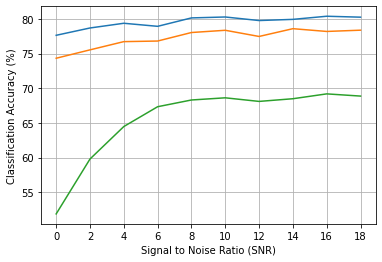

In [39]:

x_train2, x_test2 = x_train0[:,:,::2], x_test0[:,:,::2]
x_train8, x_test8 = x_train0[:,:,::8], x_test0[:,:,::8]
acc_dict1 = plot_snr_accuracy(rnn_net1, x_test0, labels, test_labels, test_idx, snrs, mods, device)
plt.plot(label = 'No Samples')
acc_dict2 = plot_snr_accuracy(rnn_net2, x_test2, labels, test_labels, test_idx, snrs, mods, device)
plt.plot(label = '1/2 Samples')
acc_dict8 = plot_snr_accuracy(rnn_net8, x_test8, labels, test_labels, test_idx, snrs, mods, device)
plt.plot(label = '1/8 Samples')